In [1]:
import cirq
import matplotlib.pyplot as plt
import sinter
import stim
from stimcirq import cirq_circuit_to_stim_circuit

from tqec.constructions.qubit import ScalableQubitSquare
from tqec.detectors.gate import ShiftCoordsGate
from tqec.detectors.transformer import fill_in_global_record_indices
from tqec.enums import PlaquetteOrientation
from tqec.generation.circuit import generate_circuit
from tqec.noise_models import (
    AfterCliffordDepolarizingNoise,
    AfterResetFlipNoise,
    BeforeMeasurementFlipNoise,
)
from tqec.plaquette.plaquette import PlaquetteList
from tqec.plaquette.library import (
    XXPlaquetteList,
    XXXXPlaquetteList,
    ZZPlaquetteList,
    ZZZZPlaquetteList,
)

from tqec.detectors.gate import ObservableGate, RelativeMeasurement
from tqec.position import Shape2D

In [2]:
def normalise_circuit(circuit: cirq.Circuit) -> cirq.Circuit:
    ordered_transformers = [
        cirq.drop_empty_moments,
    ]
    for transformer in ordered_transformers:
        circuit = transformer(circuit)
    return circuit


def to_noisy_circuit(circuit: cirq.Circuit, noise_level: float) -> cirq.Circuit:
    noise_models = [
        AfterCliffordDepolarizingNoise(noise_level),
        AfterResetFlipNoise(noise_level),
        BeforeMeasurementFlipNoise(noise_level),
    ]
    for nm in noise_models:
        circuit = circuit.with_noise(nm)
    return circuit

In [3]:
def generate_cirq_circuit_tqec(dimension: int, repetitions: int) -> cirq.Circuit:
    """Constructing the error-corrected qubit in https://doi.org/10.1038/s41586-022-05434-1."""
    template = ScalableQubitSquare(dimension)
    # Initial reset index is 1
    # (H gate for X-stabilizers is 2)
    # CNOTs indices are 3, 4, 5, 6
    # (H gate for X-stabilizers is 7)
    # Measurement index is 8
    plaquettes: list[PlaquetteList] = [
        XXPlaquetteList(
            PlaquetteOrientation.UP, [1, 2, 5, 6, 7, 8], include_detector=False
        ),
        ZZPlaquetteList(PlaquetteOrientation.LEFT, [1, 5, 6, 8]),
        XXXXPlaquetteList([1, 2, 3, 4, 5, 6, 7, 8], include_detector=False),
        ZZZZPlaquetteList([1, 3, 4, 5, 6, 8]),
        ZZPlaquetteList(PlaquetteOrientation.RIGHT, [1, 3, 4, 8]),
        XXPlaquetteList(
            PlaquetteOrientation.DOWN, [1, 2, 3, 4, 7, 8], include_detector=False
        ),
    ]

    def make_repeated_layer(circuit: cirq.Circuit) -> cirq.Circuit:
        any_qubit = next(iter(circuit.all_qubits()), None)
        assert (
            any_qubit is not None
        ), "Could not find any qubit in the given Circuit instance."
        circuit_to_repeat = (
            cirq.Circuit([ShiftCoordsGate(0, 0, 1).on(any_qubit)]) + circuit
        )
        repeated_circuit_operation = cirq.CircuitOperation(
            circuit_to_repeat.freeze()
        ).repeat(repetitions)
        return cirq.Circuit([repeated_circuit_operation])

    layer_modificators = {1: make_repeated_layer}

    circuit = cirq.Circuit()
    for layer_index in range(3):
        layer_circuit = generate_circuit(
            template,
            [plaquette_list.plaquettes[layer_index] for plaquette_list in plaquettes],
        )
        layer_circuit = normalise_circuit(layer_circuit)
        circuit += layer_modificators.get(layer_index, lambda circ: circ)(layer_circuit)

    # Compute the qubits that should be measured to get the Z logical operator.
    plaquette_shape: Shape2D = plaquettes[0].plaquettes[0].shape
    assert all(
        p.shape == plaquette_shape
        for plaquette_list in plaquettes
        for p in plaquette_list.plaquettes
    ), "All plaquettes should have exactly the same shape for the moment."
    origin = cirq.GridQubit(plaquette_shape.y - 1, plaquette_shape.x - 1)
    circuit.append(
        [
            ObservableGate(
                origin,
                [
                    RelativeMeasurement(
                        cirq.GridQubit(0, i * (plaquette_shape.x - 1)), -1
                    )
                    for i in range(dimension + 1)
                ],
            ).on(origin)
        ]
    )

    circuit_with_detectors = fill_in_global_record_indices(circuit)
    return circuit_with_detectors

In [4]:
def generate_stim_circuit_tqec(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    circuit = generate_cirq_circuit_tqec(code_distance - 1, repetitions)
    if abs(noise_level) > 1e-12:
        circuit = to_noisy_circuit(circuit, noise_level)

    return cirq_circuit_to_stim_circuit(circuit)

In [5]:
def generate_stim_circuit_stim(
    code_distance: int, noise_level: float, repetitions: int
) -> stim.Circuit:
    return stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=repetitions + 1,
        distance=code_distance,
        after_clifford_depolarization=noise_level,
        after_reset_flip_probability=noise_level,
        before_measure_flip_probability=noise_level,
        before_round_data_depolarization=0,
    )

## TQEC plots

In [8]:
surface_code_tasks_tqec = [
    sinter.Task(
        circuit=generate_stim_circuit_tqec(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]
]

collected_surface_code_stats_tqec: list[sinter.TaskStats] = sinter.collect(
    num_workers=20,
    tasks=surface_code_tasks_tqec,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

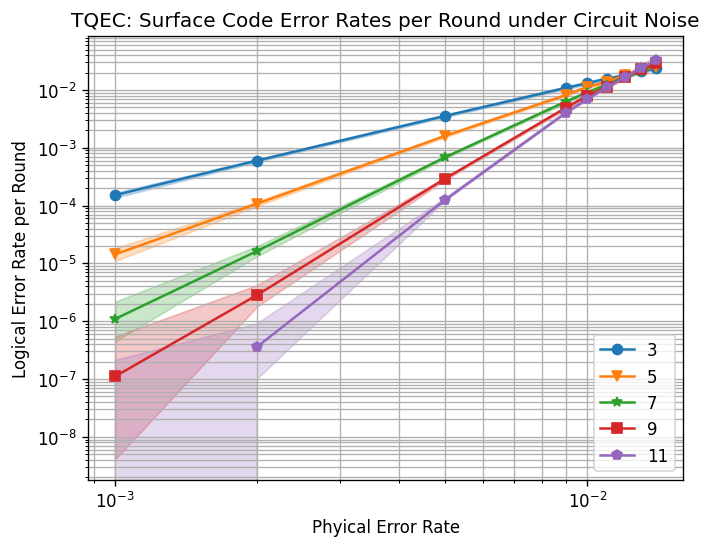

In [9]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_tqec,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("TQEC: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

## Stim plots

In [10]:
surface_code_tasks_stim = [
    sinter.Task(
        circuit=generate_stim_circuit_stim(d, noise, 3 * d),
        json_metadata={"d": d, "r": 3 * d, "p": noise},
    )
    for d in [3, 5, 7, 9, 11]
    for noise in [0.001, 0.002, 0.005, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]
]

collected_surface_code_stats_stim: list[sinter.TaskStats] = sinter.collect(
    num_workers=20,
    tasks=surface_code_tasks_stim,
    decoders=["pymatching"],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=False,
)

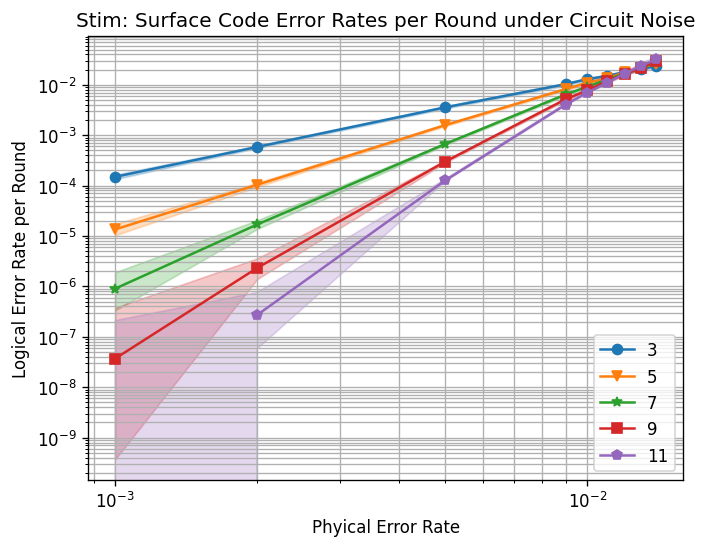

In [11]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_stim,
    x_func=lambda stat: stat.json_metadata["p"],
    group_func=lambda stat: stat.json_metadata["d"],
    failure_units_per_shot_func=lambda stat: stat.json_metadata["r"],
)
ax.loglog()
ax.set_title("Stim: Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which="major")
ax.grid(which="minor")
ax.legend()
fig.set_dpi(120)  # Show it bigger

## Circuit visualisation

In [6]:
export_stim_files = True

stim_circuit_stim = generate_stim_circuit_stim(3, 0.001, 2)
stim_circuit_tqec = generate_stim_circuit_tqec(3, 0.001, 2)
if export_stim_files:
    with open("./stim.stim", "w") as f:
        f.write(str(stim_circuit_stim))
    with open("./tqec.stim", "w") as f:
        f.write(str(stim_circuit_tqec))
    print("Export done!")

Export done!


In [ ]:
if export_stim_files:
    with open("./tqec.stim", "r") as f:
        stim_circuit_tqec = stim.Circuit(f.read())

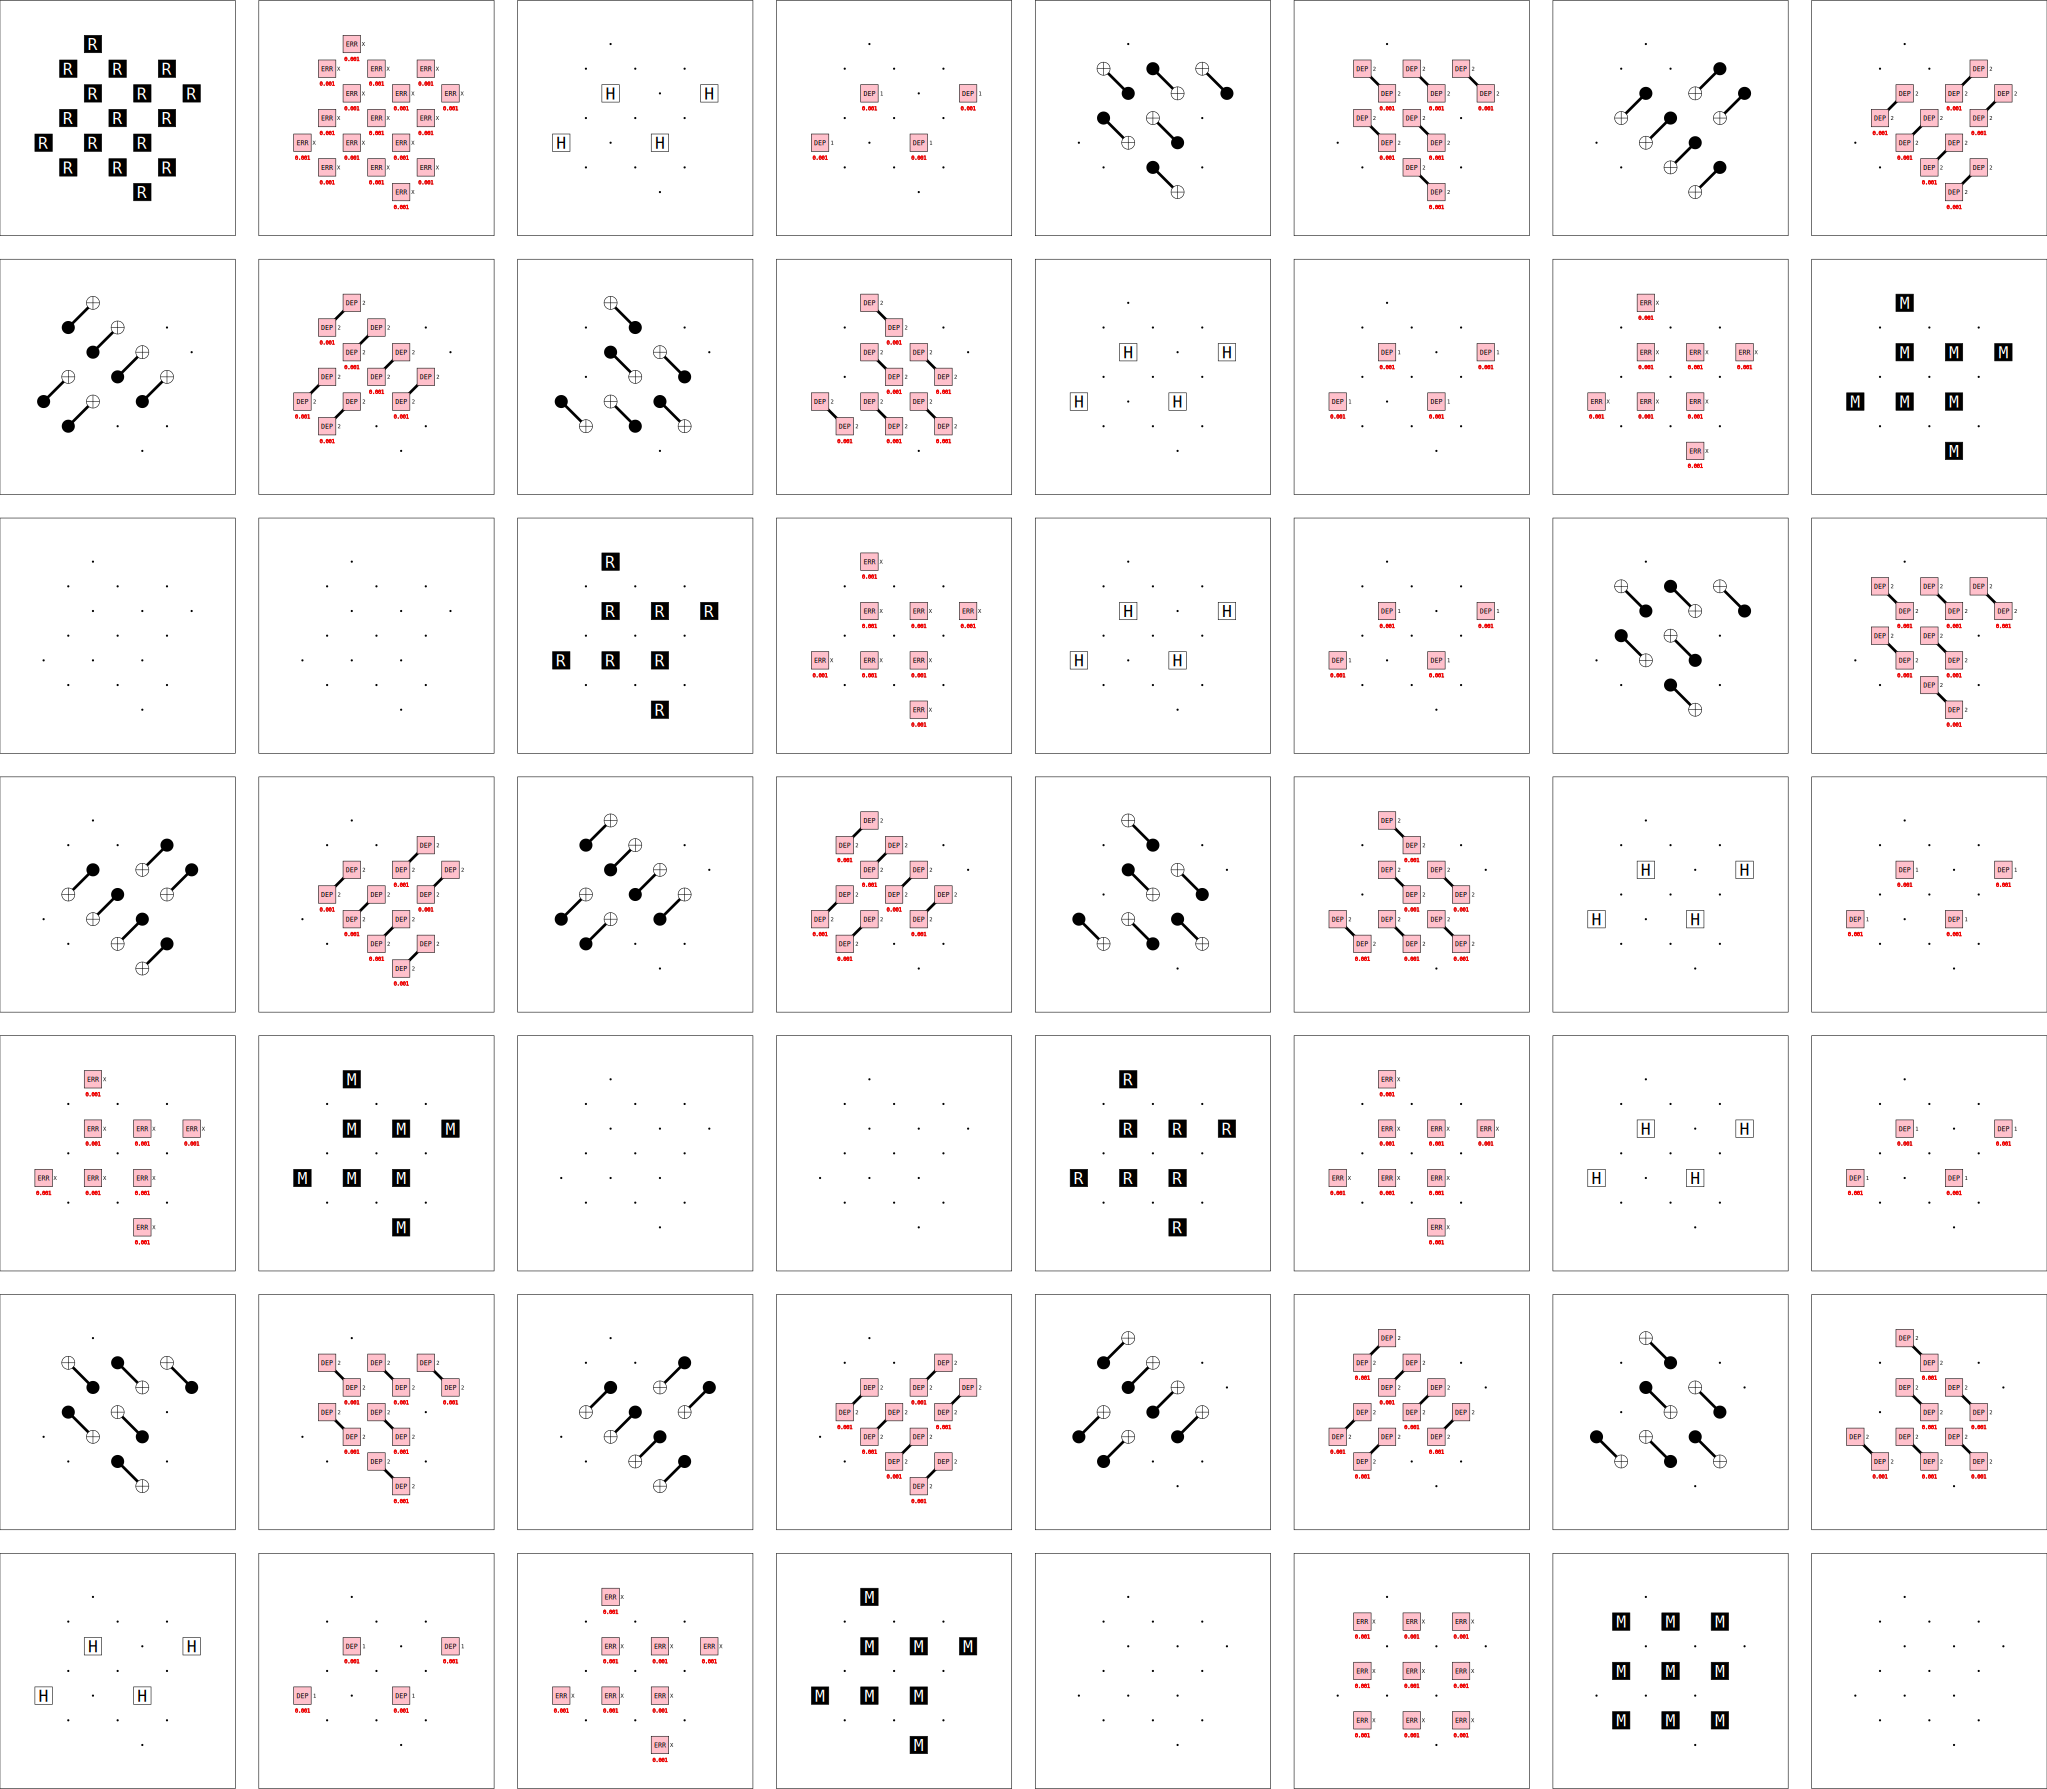

In [7]:
stim_circuit_tqec.diagram("timeslice-svg")

In [ ]:
stim_circuit_stim.diagram("timeslice-svg")